# Lecture 2 - Machine Learning Classifiers Using Scikit-Learn

### Overview

- [Choosing a classification algorithm](#Choosing-a-classification-algorithm)
- [First steps with scikit-learn](#First-steps-with-scikit-learn)
    - [Training a perceptron via scikit-learn](#Training-a-perceptron-via-scikit-learn)
- [Modeling class probabilities via logistic regression](#Modeling-class-probabilities-via-logistic-regression)
    - [Logistic regression intuition and conditional probabilities](#Logistic-regression-intuition-and-conditional-probabilities)
    - [Learning the weights of the logistic loss function](#Learning-the-weights-of-the-logistic-loss-function)
    - [Training a logistic regression model with scikit-learn](#Training-a-logistic-regression-model-with-scikit-learn)
    - [Tackling overfitting via regularization](#Tackling-overfitting-via-regularization)
- [Maximum margin classification with support vector machines](#Maximum-margin-classification-with-support-vector-machines)
    - [Maximum margin intuition](#Maximum-margin-intuition)
    - [Dealing with the nonlinearly separable case using slack variables](#Dealing-with-the-nonlinearly-separable-case-using-slack-variables)
    - [Alternative implementations in scikit-learn](#Alternative-implementations-in-scikit-learn)
- [Solving nonlinear problems using a kernel SVM](#Solving-non-linear-problems-using-a-kernel-SVM)
    - [Using the kernel trick to find separating hyperplanes in higher dimensional space](#Using-the-kernel-trick-to-find-separating-hyperplanes-in-higher-dimensional-space)

In [1]:
from IPython.display import Image
%matplotlib inline

# Choosing a classification algorithm

In practice,
- compare the performance of at least a handful of different learning algorithms to select the best model for the particular problem
- the best algortihm choice will differ in the number of features or examples, the amount of noise in a dataset, and whether the
classes are linearly separable.

### Training a supervised machine learning algorithm

1. Selecting features and collecting labeled training examples
2. Choosing a performance metric
3. Choosing a learning algorithm and training a model
4. Evaluating the performance of the model
5. Changing the settings of the algorithm and tuning the model.

We will not cover feature selection and preprocessing, performance metrics, and hyperparameter tuning in this course.

# First steps with scikit-learn

We continue to use the linearly separable Iris dataset. We can load this dataset directly from scikit-learn. Here, the third column represents the petal length, and the fourth column the petal width of the flower examples. The classes are already converted to integer labels where 0=<tt>Iris-Setosa</tt>, 1=<tt>Iris-Versicolor</tt>, 2=<tt>Iris-Virginica</tt>.

In [2]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


To evaluate the performance of a trained model on unseen data, we split the dataset into separate training and test datasets. We randomly split the data into 70% training (105 examples) and 30% test (45 examples) data.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# random_state : controls shuffling order
# stratify over y : each set contains approximately the same percentage of samples of each target class as the complete set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [4]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


##### Standardizing the features (preprocessing)

In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train) # computes mean and std dev for each dimension
X_train_std = sc.transform(X_train) # Perform standardization by centering and scaling
X_test_std = sc.transform(X_test) 

## Training a perceptron via scikit-learn

In [6]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

Unlike in Lecture 1 where we only used binary classification, here we are able to feed three flower classes simultaneously to the linear perceptron model. The multiclass classification is done via **one-versus-rest** (**OvR**) method. **eta0** is the learning rate parameter, and **random_state** parameter ensures the reproducibility. 

Once the model is trained via the **fit** method, we can make predictions via the **predict** method.

In [7]:
y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 1


##### Performance metrics

There is a wide range of performance metrics available in scikit-learn via the **metrics** module. For example, the classification score is the most basic one. 

In [8]:
from sklearn.metrics import accuracy_score

print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.978


##### Use the in-built score function in the classifier

In [9]:
print('Accuracy: %.3f' % ppn.score(X_test_std, y_test))

Accuracy: 0.978


##### Function to plot decision regions

In [10]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='Test set')        

Note above, that we can now mark the indices of the examples with different markers. Next, we train a perceptron model using the standardized training data:

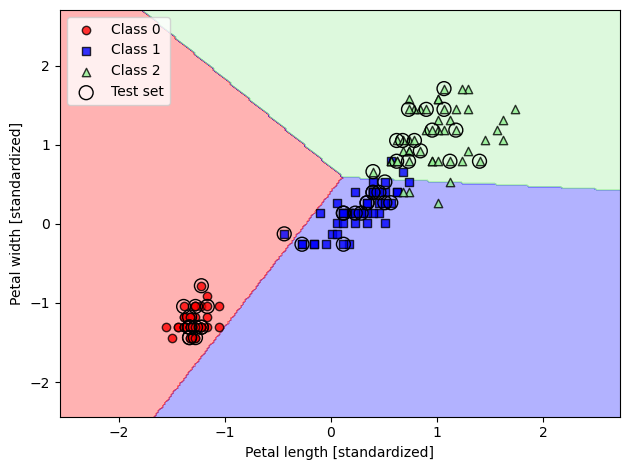

In [11]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Recall that the perceptron algorithm never converges on datasets that are not perfectly linearly separable, which is why the use of the perceptron algorithm is typically not recommended in practice.

<br>
<br>

# Modeling class probabilities via logistic regression

Even though the perceptron model is easy to understand and implement for classification, its biggest disadvantage is that it never converges if the classes are not perfectly linearly separable. Another simple, yet more powerful, algorithm for linear and binary classification problems is **logistic regression**. Note that, despite its name, logistic regression is a model for classification, not regression. 

Similar to the perceptron and Adaline, the logistic regression model in this chapter is also a linear model for binary classification.

### Logistic regression intuition and conditional probabilities

Let us first introduce the term **odds**, that is, the odds in favour of a particular event. The odds can be written as $\frac{p}{1-p}$, where $p$ stands for the probability of the positive event. The term "positive event" refers to the event that we want to predict. We can think of the positive event with a class label $y = 1.$ For brevity, we can define the probability $p$ as $p := p(y = 1|x)$, the conditional probability that a particular example belongs to a certain class 1 given
its features, $x$.

We then define the **logit** function, which is simply the logarithm of the odds (log-odds):
\begin{equation}
logit(p) = \log \frac{p}{1-p}.
\end{equation}
The logit function takes input values in the range 0 to 1 and transforms them into values over the entire real-number range.

Under the logistic model, we assume that there is a linear relationship between the weighted inputs (net inputs) and the log-odds:
\begin{equation}
logit(p) = w_1 x_1 + \ldots + w_m x_m + b = \sum^m_{j=1} w_j x_j + b = \mathbf{w}^\top \mathbf{x} +b.
\end{equation}

Thus, in the above, we are making an assumption on the relationship between the logit function and the net inputs. We can consider the inverse of the logit function to map the real-number range back to a $[0, 1]$ range for the probability $p$.

The inverse of the logit function is called the logistic sigmoid function, which is sometimes simply abbreviated to sigmoid function due to its characteristic S-shape:
\begin{equation}
\sigma(z) = \frac{1}{1+e^{-z}}, z = \mathbf{w}^\top \mathbf{x} +b.
\end{equation}
We plot the sigmoid function below.

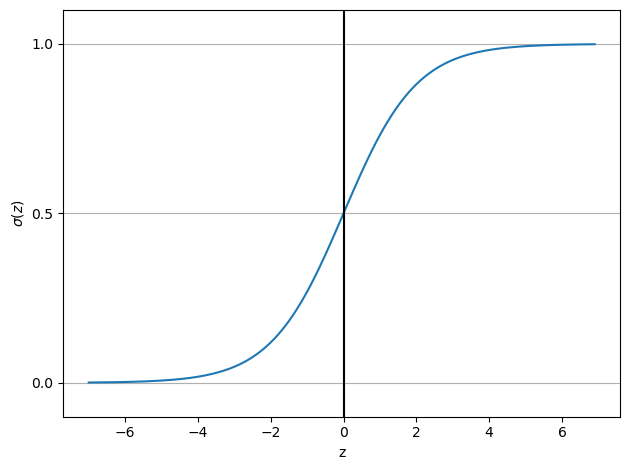

In [12]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
sigma_z = sigmoid(z)

plt.plot(z, sigma_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\sigma (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

We can see that $\sigma(z)$ approaches 1 if $z$ goes toward infinity ($z \to \infty$) since $e^{-z}$ becomes very small for large values of $z$. Similarly, $\sigma(z)$ goes toward 0 for $z \to -\infty$ as a result of an increasingly large denominator.
Thus, we can conclude that this sigmoid function takes real-number values as input and transforms them into values in the range $[0, 1]$ with an intercept at $\sigma(0) = 0.5.$

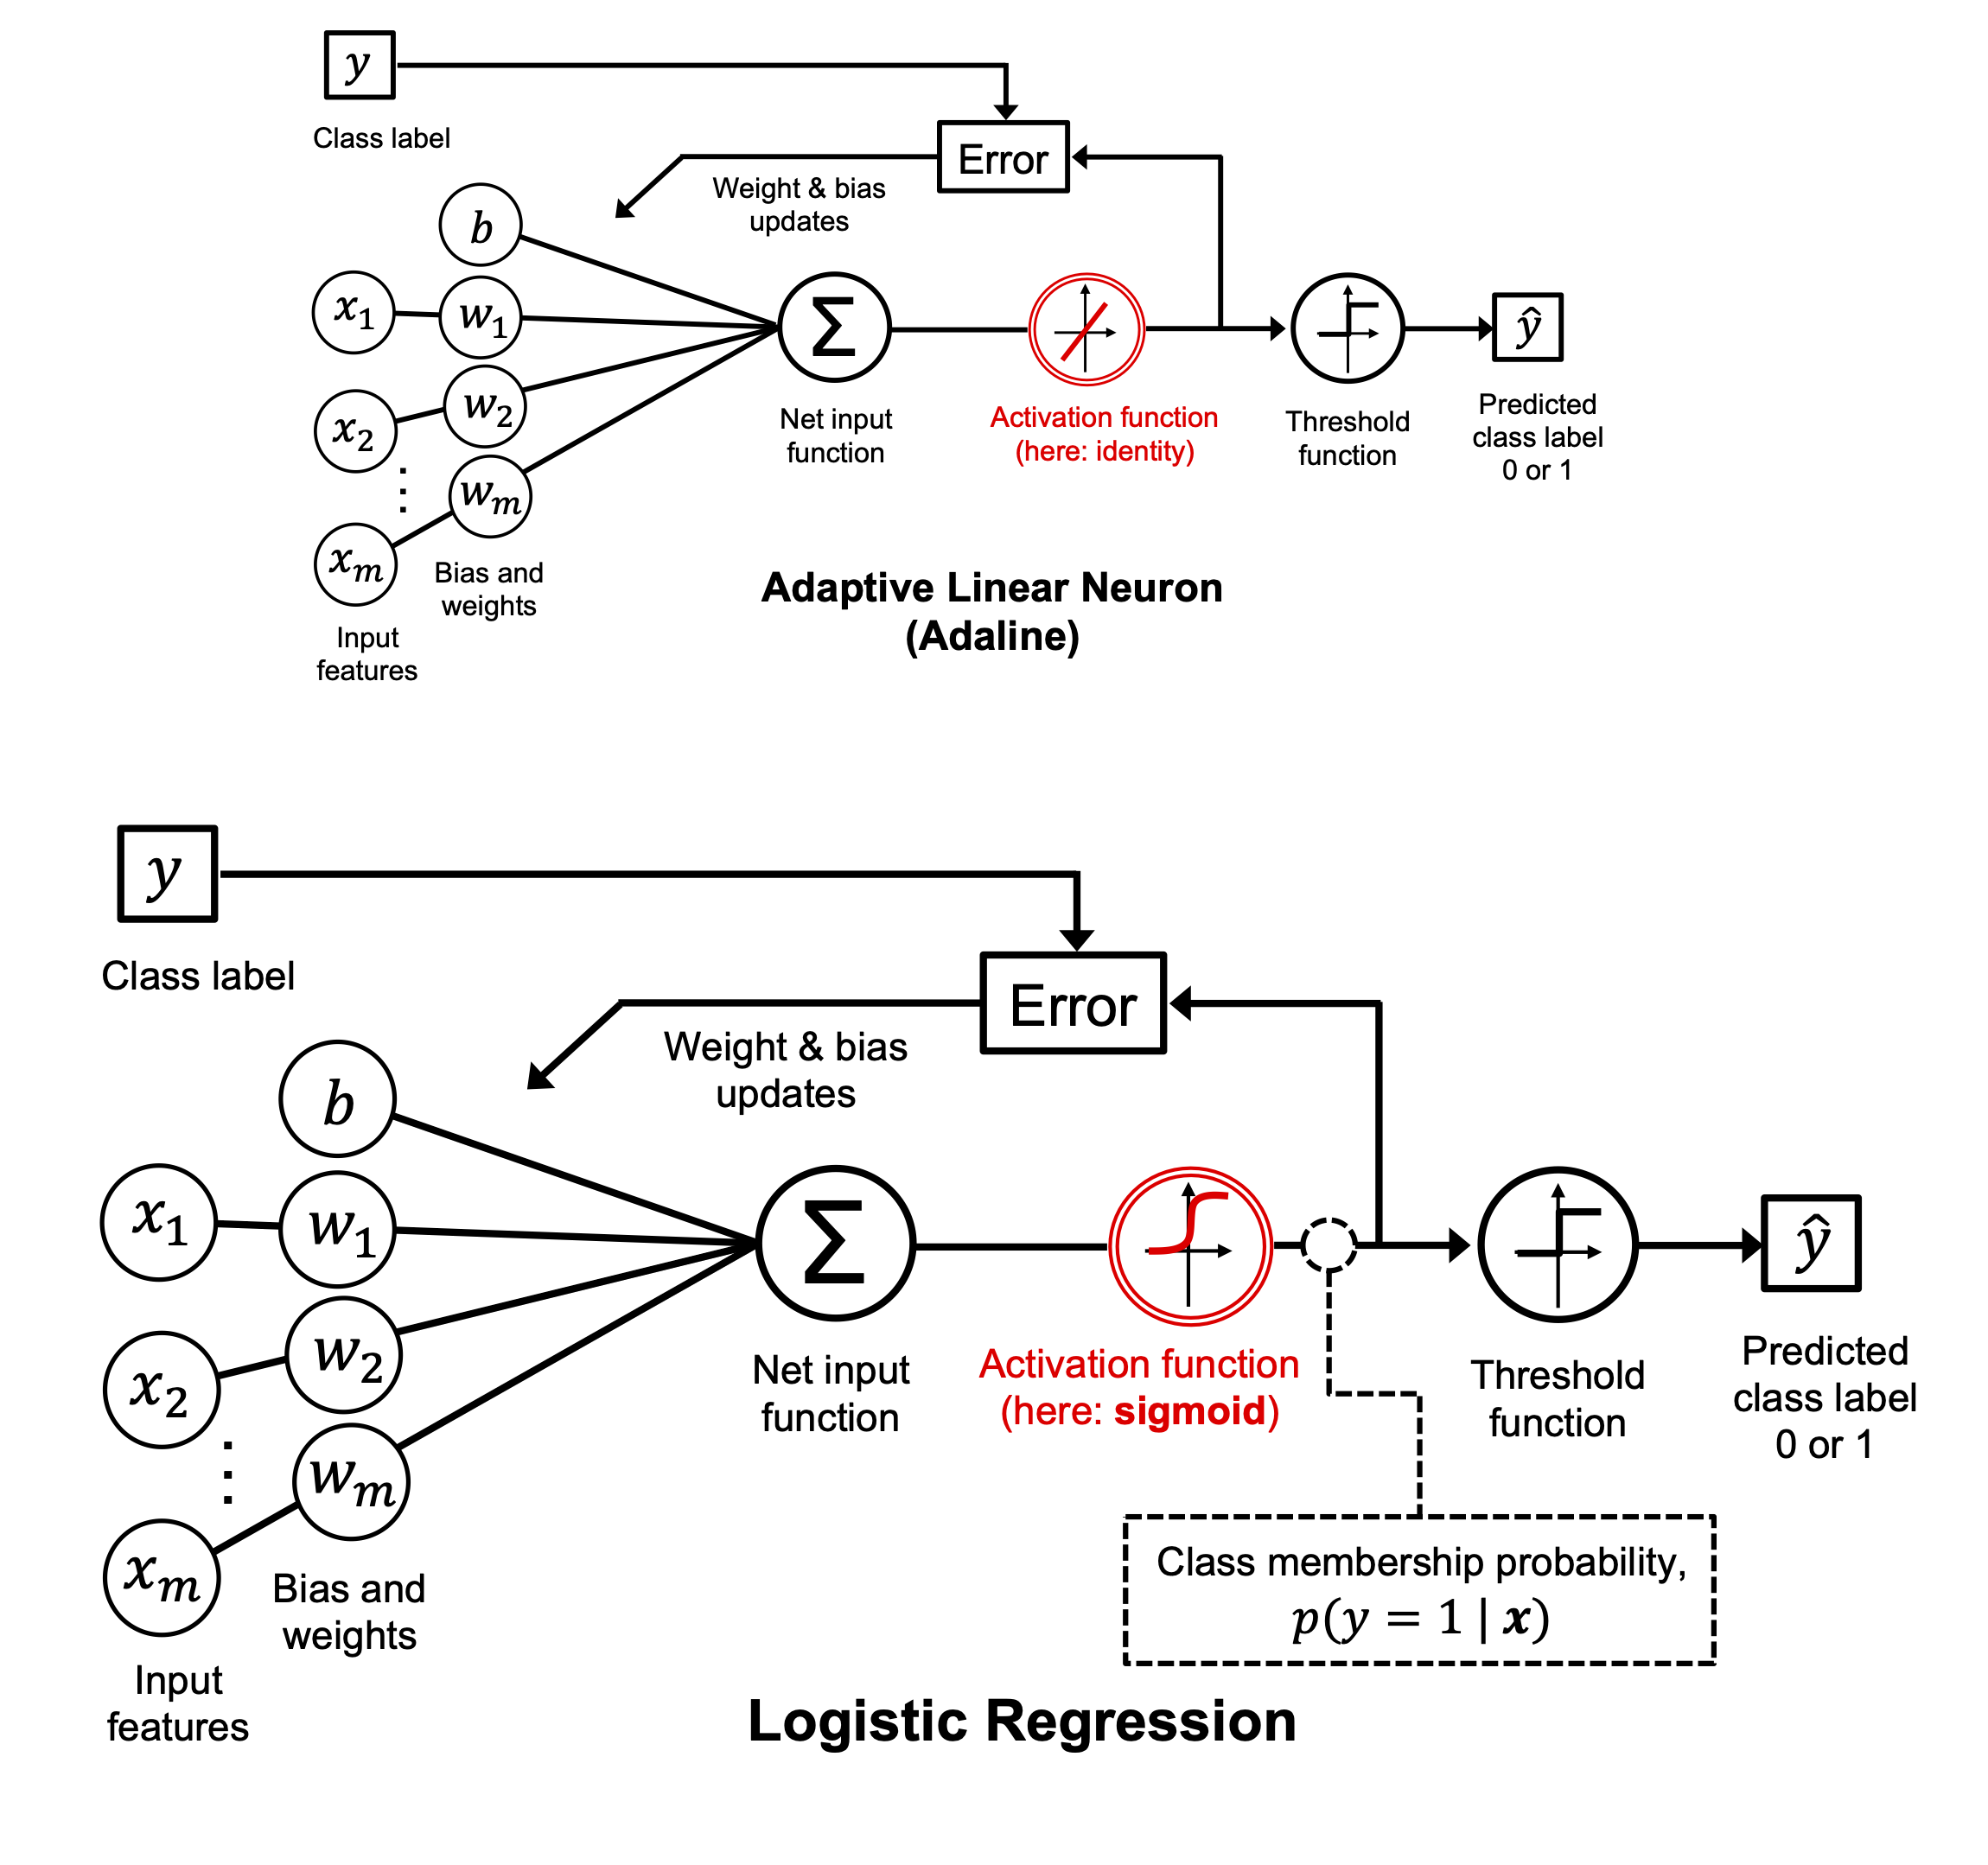

In [13]:
Image(filename='figures/03_03.png', width=500) 

In Adaline, we use the identity function $\sigma(z) =z$ as the activation function. In logistic regression, this activation
function simply becomes the sigmoid function that we defined earlier. The output of the sigmoid function is then interpreted as the probability of a particular example belonging to class 1, $\sigma(z) = p(y = 1| \mathbf{x};\mathbf{w},b)$, given its features $x$, and parameterized by the weights and bias, $\mathbf{w}$ and $b$. 

For example, if we compute $\sigma(z) = 0.8$ for a particular flower example, it means that the chance that this example is an <tt>Iris-versicolor</tt> flower is 80 percent. Therefore, the probability that this flower is an <tt>Iris-setosa</tt> flower can be calculated as
$p(y = 0| \mathbf{x};\mathbf{w},b) = 1 – p(y = 1| \mathbf{x};\mathbf{w},b)$ = 0.2, or 20 percent.

The predicted probability can then simply be converted into a binary outcome via a threshold function
\begin{equation}
\widehat{y} = \begin{cases}
1 & \text{if } \sigma(z)  \geq 0.5\\
0 & \text{otherwise}
\end{cases}
\end{equation}

If we look at the preceding plot of the sigmoid function, this is equivalent to the following:
\begin{equation}
\widehat{y} = \begin{cases}
1 & \text{if } z \geq 0\\
0 & \text{otherwise}
\end{cases}
\end{equation}

There are many applications where we are not only interested in the predicted class labels, but where the estimation of the class-membership probability is particularly useful. Logistic regression is used in weather forecasting, for example, not only to predict whether it will rain on a particular day, but also to report the chance of rain.

<br>
<br>

### Learning the weights of the logistic loss function

To explain how we can derive the loss function for logistic regression, let us first define the likelihood $\mathcal{L}$ that we want to maximize when we build a logistic regression model, assuming that the individual examples in our dataset are independent of one another. The formula is as follows:
\begin{equation}
\mathcal{L}(\mathbf{w},b|\mathbf{x}) = p(y|\mathbf{x};\mathbf{w},b)= \prod^n_{i=1}p(y^{(i)}|\mathbf{x}^{(i)};\mathbf{w},b) = \prod^n_{i=1} \bigl( \sigma(z^{(i)})\bigr)^{y^{(i)}}\bigl(1 -\sigma(z^{(i)})\bigr)^{1-y^{(i)}}.
\end{equation}
In practice, it is easier to maximize the (natural) log of this equation, which is called the **log-likelihood function**:
\begin{equation}
\ell(\mathbf{w},b|\mathbf{x}) = \log \mathcal{L}(\mathbf{w},b|\mathbf{x}) = \sum^n_{i=1}\Bigl[y^{(i)} \log\bigl(\sigma(z^{(i)})\bigr) + (1-y^{(i)})\log\bigl(1 - \sigma(z^{(i)})\bigr)  \Bigr].
\end{equation}
Firstly, applying the log function reduces the potential for numerical underflow, which can occur if the likelihoods are very small. Secondly, we can convert the product of factors into a summation of factors, which makes it easier to obtain the derivative of this function.

We could use an optimization algorithm such as gradient ascent to maximize this log-likelihood function. Gradient ascent works exactly the same way as gradient descent except that gradient ascent maximizes a function instead of minimizing it.

The resulting plot shows the sigmoid activation on the $x$ axis in the range 0 to 1 (the inputs to the sigmoid function were $z$ values in the range –10 to 10) and the associated logistic loss on the $y$ axis.

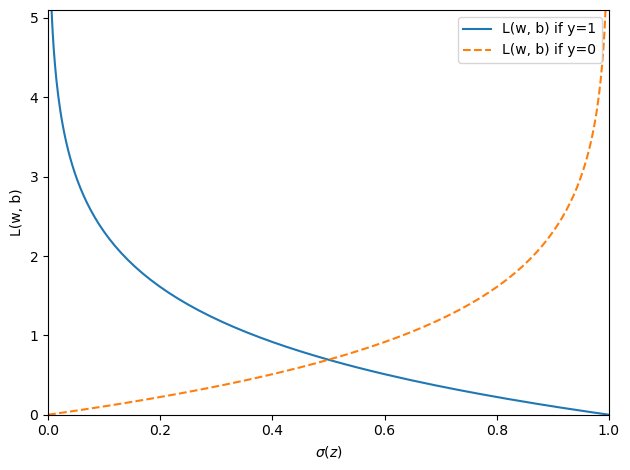

In [14]:
def loss_1(z):
    return - np.log(sigmoid(z))


def loss_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
sigma_z = sigmoid(z)

c1 = [loss_1(x) for x in z]
plt.plot(sigma_z, c1, label='L(w, b) if y=1')

c0 = [loss_0(x) for x in z]
plt.plot(sigma_z, c0, linestyle='--', label='L(w, b) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\sigma(z)$')
plt.ylabel('L(w, b)')
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('figures/03_04.png', dpi=300)
plt.show()

We can see that the loss approaches 0 (continuous line) if we correctly predict that an example belongs to class 1. Similarly, we can see on the $y$ axis that the loss also approaches 0 if we correctly predict $y$ = 0 (dashed line). However, if the prediction is wrong, the loss goes toward infinity. The main point is that we penalize wrong predictions with an increasingly larger loss.

### Converting an Adaline implementation into an algorithm for logistic regression

If we were to implement logistic regression ourselves, we could simply substitute the loss function, $L$, in our Adaline 
implementation from Lecture 1, with the new loss function:
\begin{equation}
L(\mathbf{w},b) = \frac{1}{n} \sum^n_{i=1}\Bigl[-y^{(i)}\log\bigl(\sigma(z^{(i)})\bigr) - (1-y^{(i)}) \log\bigl(1-\sigma(z^{(i)})\bigr)\Bigr].
\end{equation}
We use this to compute the loss of classifying all training examples per epoch. Also, we need to swap the linear activation function with the sigmoid. If we make those changes to the Adaline code, we will end up with a working logistic regression implementation. The following is an implementation for full-batch gradient descent (but note that the same changes could be made to the stochastic gradient descent version as well):

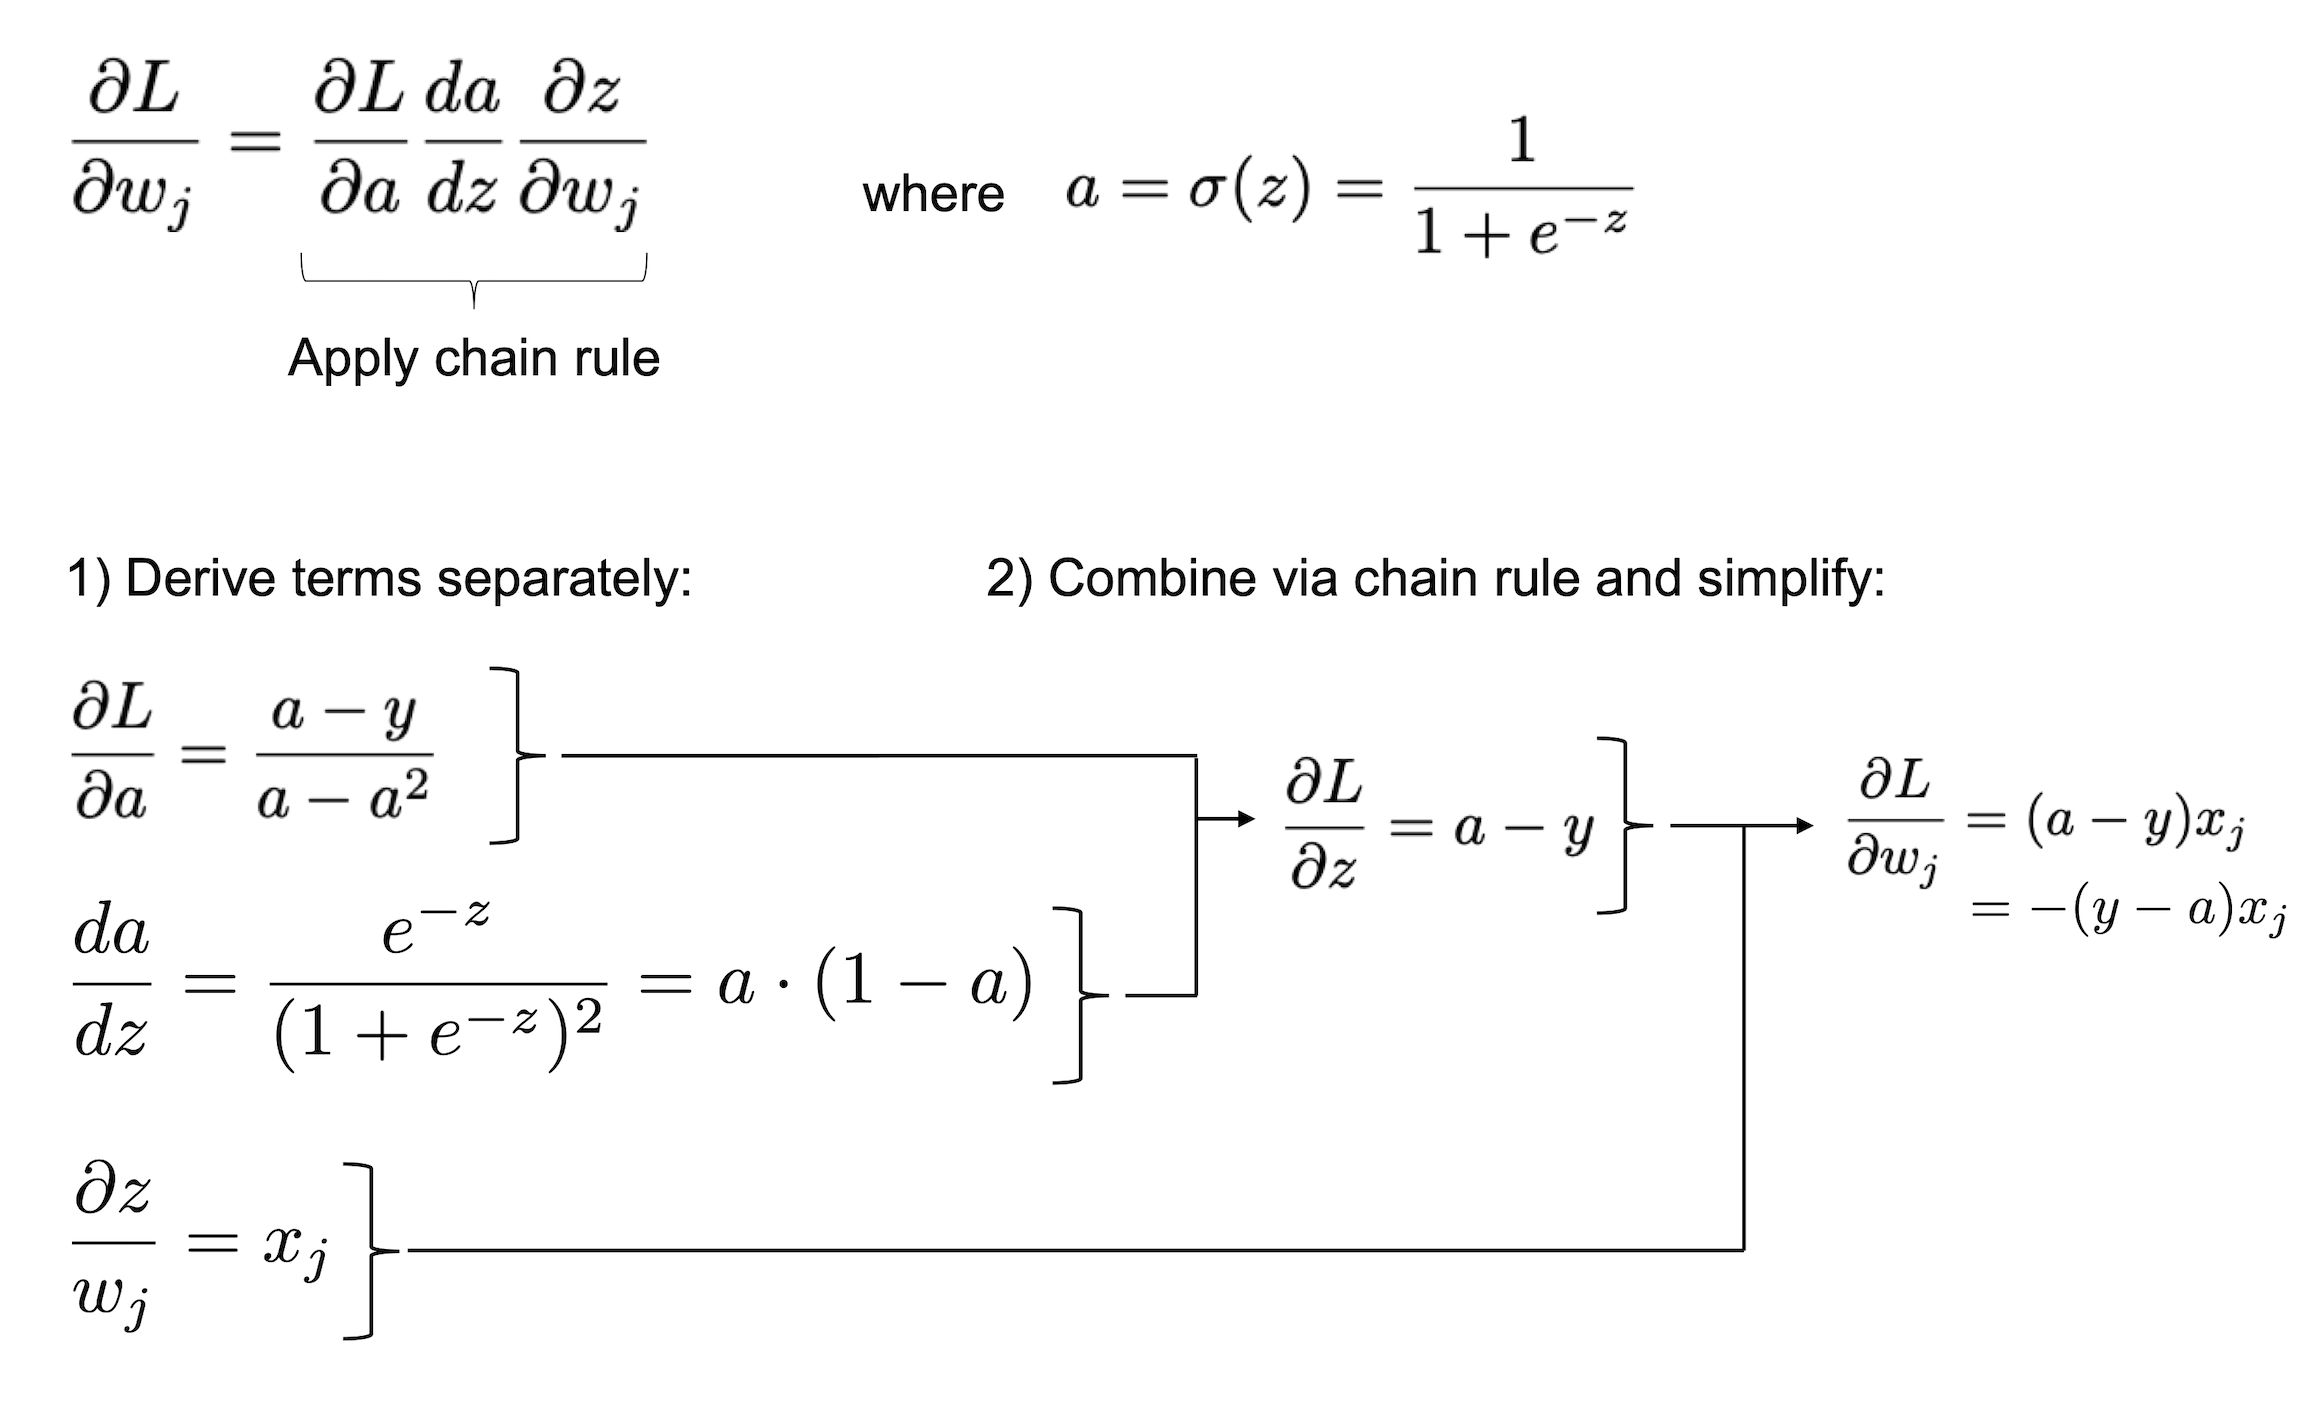

In [15]:
Image(filename='figures/03_25.png', width=500) 

Note that we omitted averaging over the training examples for brevity. Remember from Lecture 1 that we take steps in the opposite direction of the gradient. Hence, we flip $\frac{\partial L}{\partial w_j} = -(y-a)x_j$ and update the $j$th weight as follows, including the learning rate $\eta:$
\begin{equation}
w_j := w_j + \eta (y-a)x_j.
\end{equation}
While the partial derivative of the loss function with respect to the bias unit is not shown, bias derivation follows the same overall concept using the chain rule, resulting in the following update rule:
\begin{equation}
b := b + \eta (y-a).
\end{equation}

In [16]:
class LogisticRegressionGD:
    """Gradient descent-based logistic regression classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after training.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared error loss function values in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : Instance of LogisticRegressionGD

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * errors.mean()
            loss = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output))) / X.shape[0]
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

When we fit a logistic regression model, we have to keep in mind that it only works for binary classification tasks. So, let us consider only setosa and versicolor flowers (classes 0 and 1) and check that our implementation of logistic regression works:

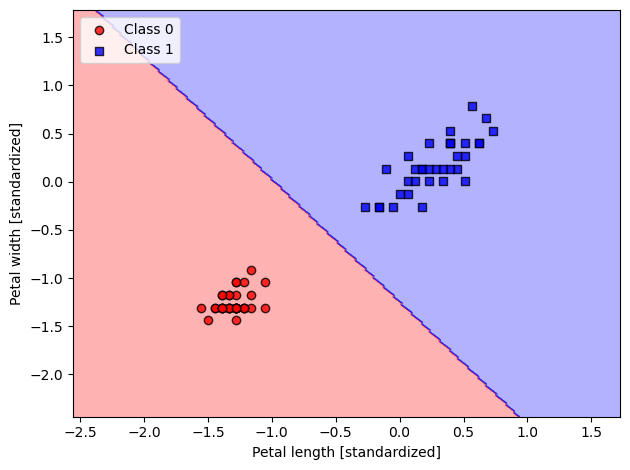

In [17]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Training a logistic regression model with scikit-learn

Let us learn how to use scikit-learn's more optimized implementation of logistic regression, which also supports multiclass settings. In the following code example, we will use the **sklearn.linear_model.LogisticRegression** class as well as the familiar **fit** method to train the model on all three classes in the standardized flower training dataset. Also, we set **multi_class='ovr'** for illustration purposes. Other option is **multi_class='multinomial'**. Note that the multinomial setting is now the default choice in scikitlearn’s **LogisticRegression** class and recommended in practice for mutually exclusive classes, such as those found in the Iris dataset. Here, "mutually exclusive" means that each training example can
only belong to a single class (in contrast to multilabel classification, where a training example can be a member of multiple classes).

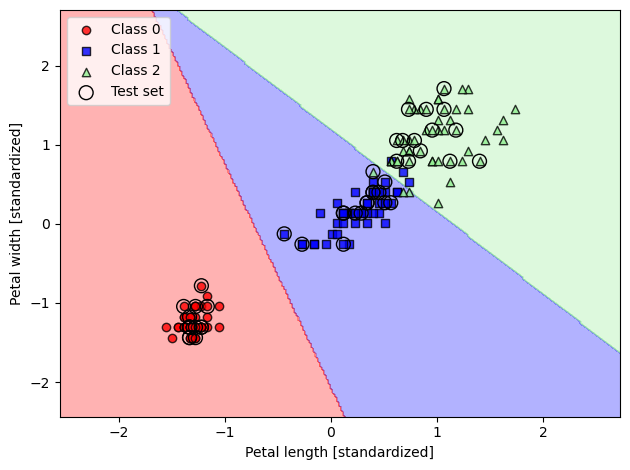

In [18]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

The parameter $C$ used above is a regularization parameter which is used to control overfitting. The probability that training examples belong to a certain class can be computed using the **predict_proba** method. For example, we can predict the probabilities of the first three examples in the test dataset as follows:

In [19]:
lr.predict_proba(X_test_std[:3, :])

array([[3.81527885e-09, 1.44792866e-01, 8.55207131e-01],
       [8.34020679e-01, 1.65979321e-01, 3.25737138e-13],
       [8.48831425e-01, 1.51168575e-01, 2.62277619e-14]])

The first row corresponds to the class membership probabilities of the first flower, the second row corresponds to the class membership probabilities of the second flower, and so forth. Notice that the column-wise sum in each row is 1, as expected

In [20]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

The highest value in the first row is approximately 0.85, which means that the first example belongs to class 3 (<tt>Iris-virginica</tt>) with a predicted probability of 85 percent. 

In [21]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0], dtype=int64)

In practice, the more convenient way of obtaining class labels when using scikit-learn is to call the **predict** method directly:

In [22]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

If we want to predict the class label of a single flower example: scikit-learn expects a two-dimensional array as data input; thus, we have to convert a single row slice into such a format first. One way to convert a single row entry into a two-dimensional data array is to use NumPy's reshape method to add a new dimension.

In [23]:
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

### Tackling overfitting via regularization

Overfitting is a common problem in machine learning, where a model performs well on training data but does not generalize well to unseen data (test data). If a model suffers from overfitting, we also say that the model has a high variance, which can be caused by having too many parameters, leading to a model that is too complex given the underlying data. Similarly, our model can also suffer from underfitting (high bias), which means that our model is not complex enough to capture the pattern in the training data well and therefore also suffers from low performance on unseen data. 

Although we have only encountered linear models for classification so far, the problems of overfitting and underfitting can be best illustrated by comparing a linear decision boundary to more complex, nonlinear decision boundaries.

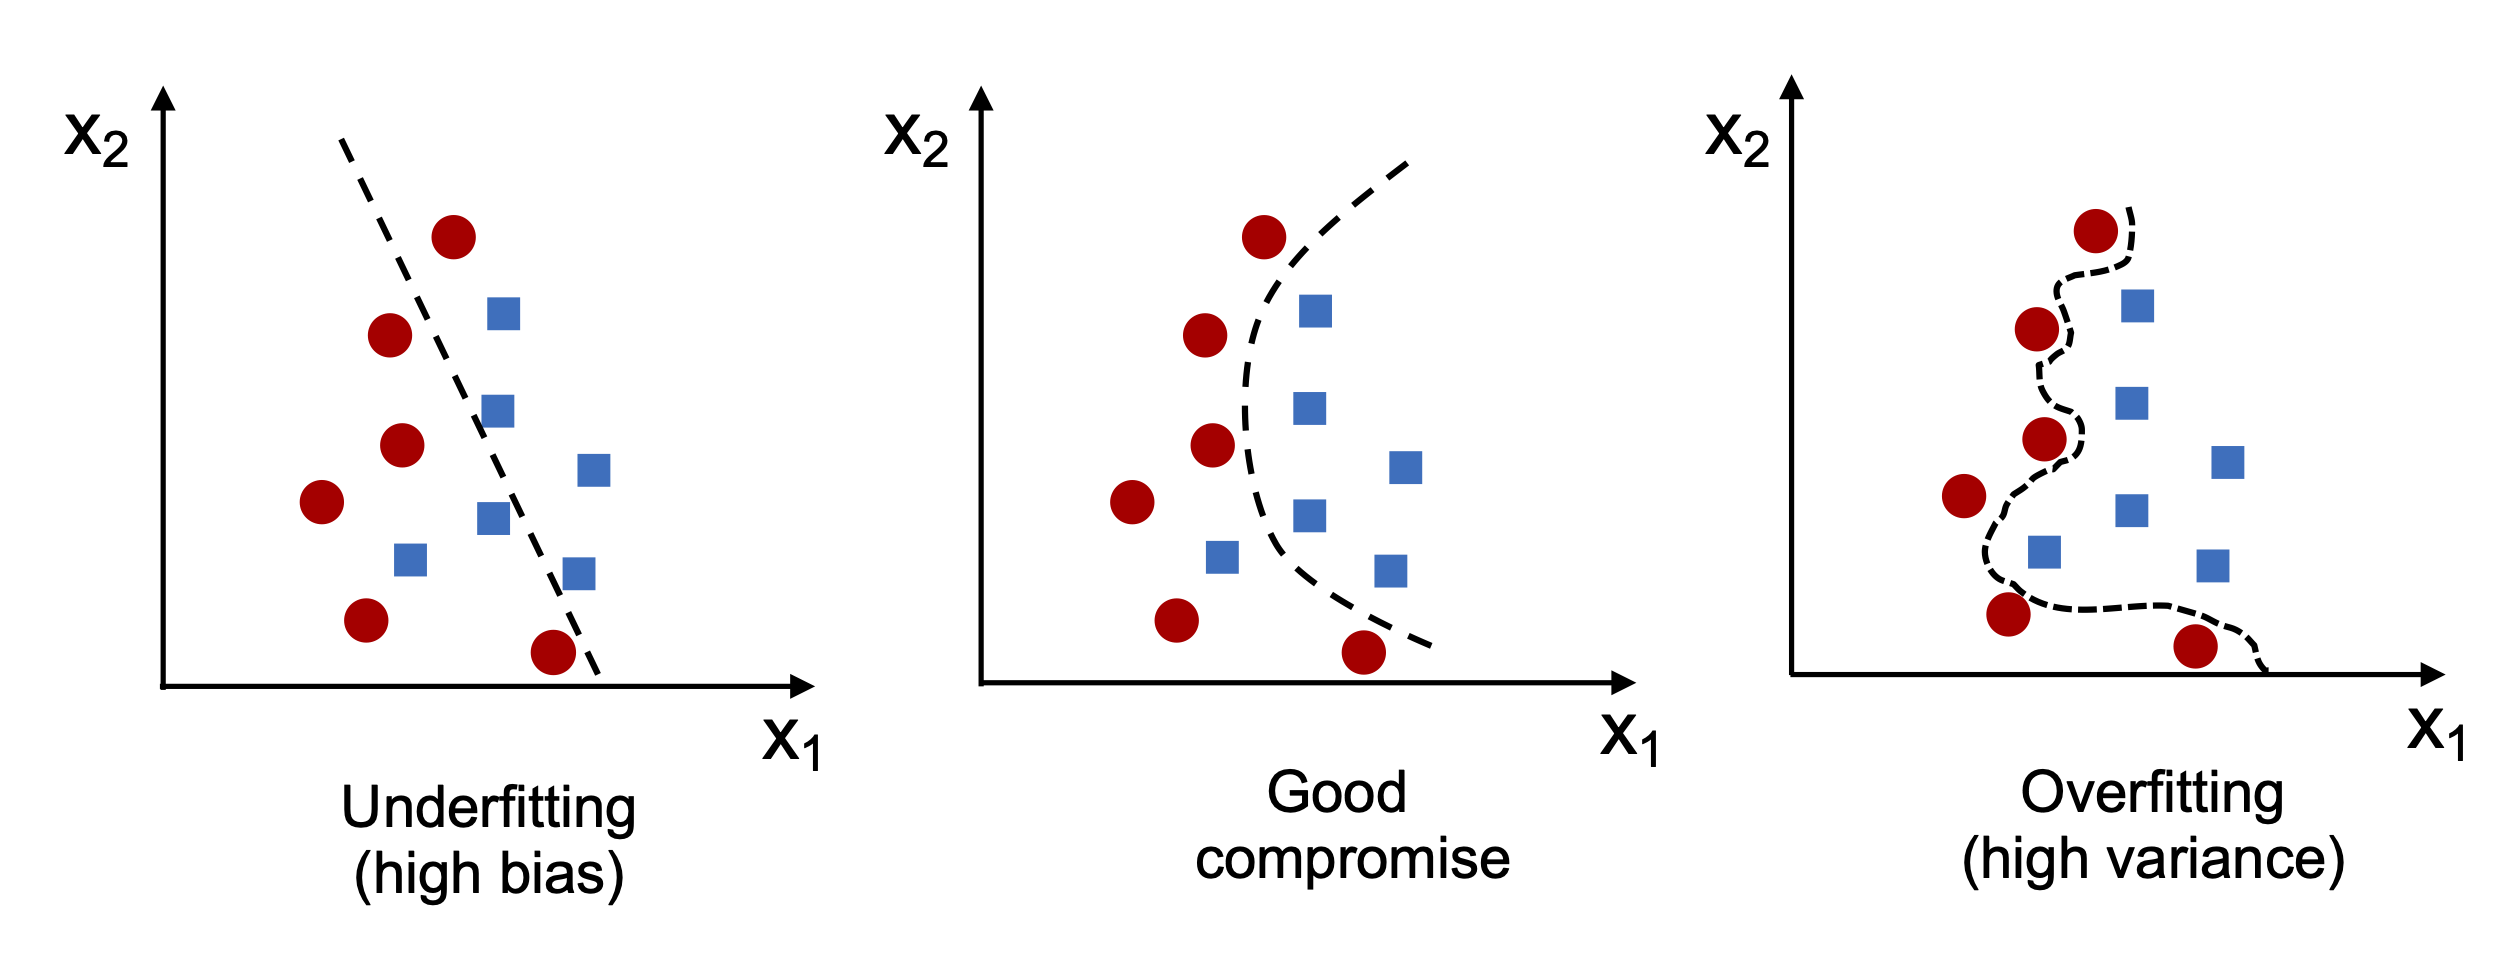

In [24]:
Image(filename='figures/03_07.png', width=700) 

One way of finding a good bias-variance tradeoff is to tune the complexity of the model via regularization. Regularization is a very useful method for handling collinearity (high correlation among features), filtering out noise from data, and eventually preventing overfitting.

The concept behind regularization is to introduce additional information to penalize extreme parameter (weight) values. The most common form of regularization is so-called **L2 regularization** (sometimes also called L2 shrinkage or weight decay), which can be written as follows:
\begin{equation}
\frac{\lambda}{2n}\| w\|^2 = \frac{\lambda}{2n}\sum^m_{j=2}w_j^2.
\end{equation}
Here $\lambda$ is called the so-called **regularization** parameter. The sample size n is added to
scale the regularization term similar to the loss.

Adding the regularization term to the loss changes the partial derivative to the following form:
\begin{equation}
\frac{\partial L(\mathbf{w},b)}{\partial w_j} = \left( \frac{1}{n}\sum^n_{i=1} \Bigl(\sigma\bigl(\mathbf{w}^\top\mathbf{x}^{(i)}\bigr) - y^{(i)} \Bigr)x_j^{(i)} \right) + \frac{\lambda}{n}w_j.
\end{equation}

Via the regularization parameter, $\lambda$ , we can then control how closely we fit the training data, while keeping the weights small. By increasing the value of $\lambda$, we increase the regularization strength. Please note that the bias unit, which is essentially an intercept term or negative threshold is usually not regularized.

The parameter, $C$, that is implemented for the LogisticRegression class in scikit-learn comes from
a convention in support vector machines, which will be the next topic. The term $C$ is
inversely proportional to the regularization parameter, $\lambda$. Consequently, decreasing the value of the inverse regularization parameter, $C$, means that we are increasing the regularization strength, which we can visualize by plotting the L2 regularization path for the two weight coefficients.

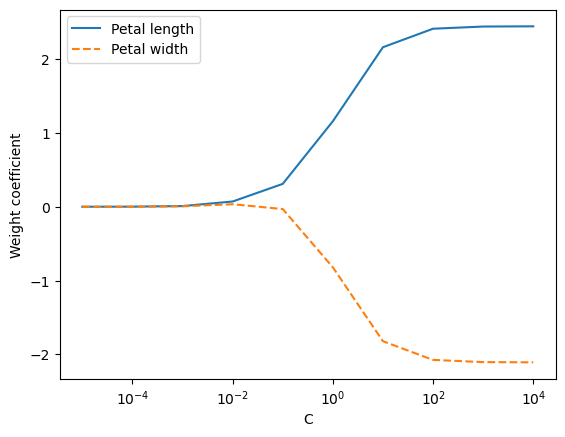

In [25]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='Petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='Petal width')
plt.ylabel('Weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
#plt.savefig('figures/03_08.png', dpi=300)
plt.show()

We fitted 10 logistic regression models with different values for the inverse-regularization parameter, $C$. For illustration purposes, we only collected the weight coefficients
of class 1 (here, the second class in the dataset: <tt>Iris-versicolor</tt>) versus all classifiers—remember that we are using the OvR technique for multiclass classification. As we can see in the resulting plot, the weight coefficients shrink if we decrease parameter C, that is, if we increase the regularization strength.

Increasing the regularization strength can reduce overfitting, but we cannot strongly regularize all models by default. If the regularization strength is too high and the weights coefficients approach zero, the model can perform very poorly due to underfitting.

<br>
<br>

# Maximum margin classification with support vector machines

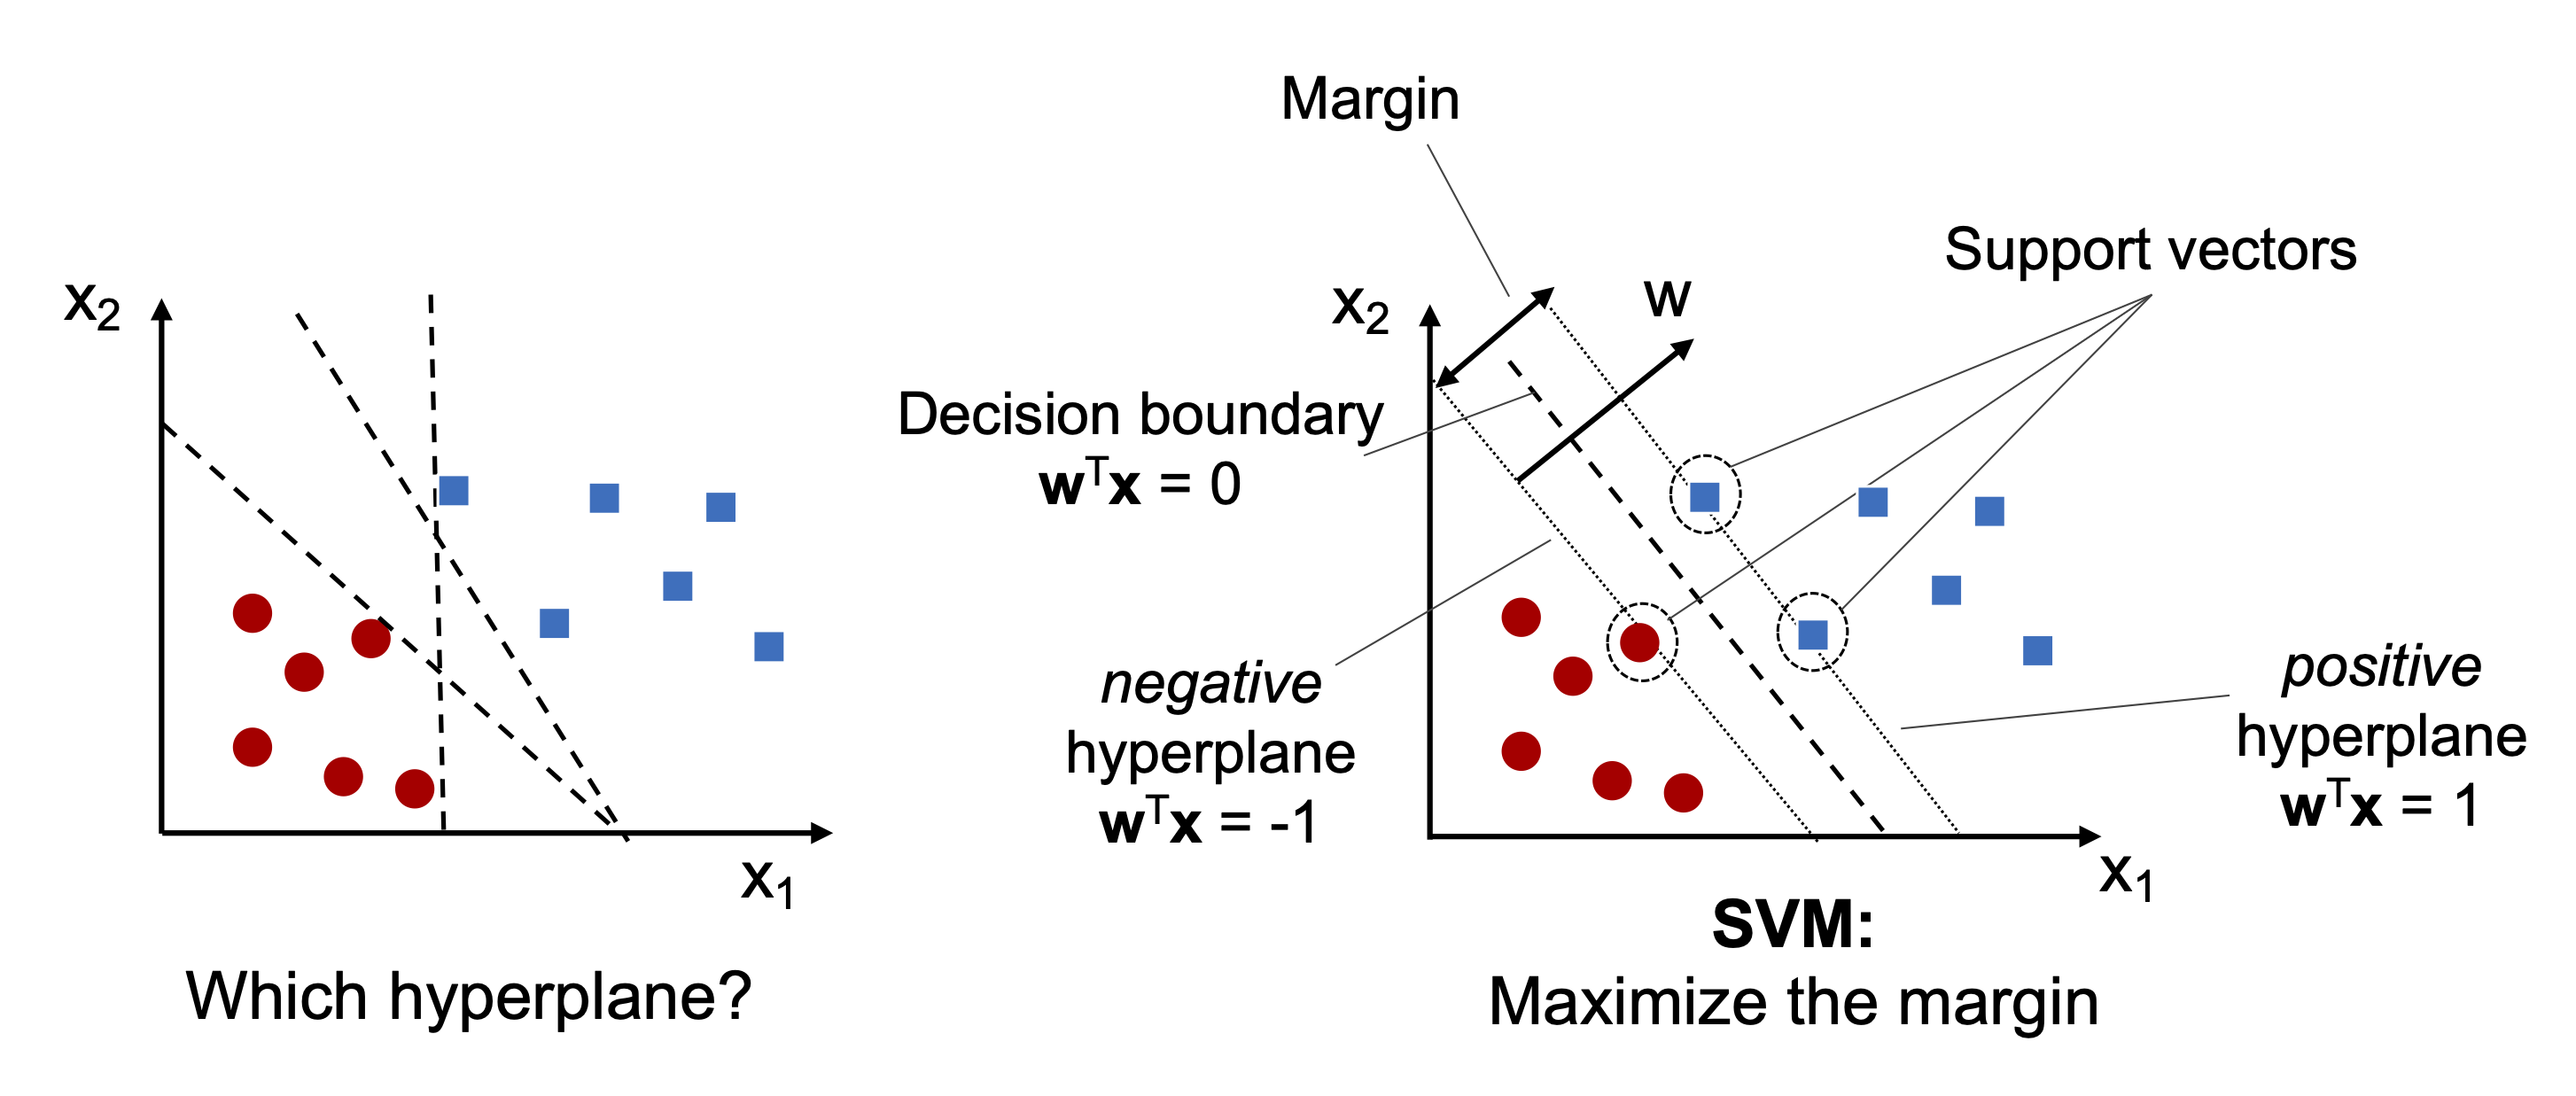

In [26]:
Image(filename='figures/03_09.png', width=700) 

Another powerful and widely used learning algorithm is the **support vector machine** (SVM), which
can be considered an extension of the perceptron. Using the perceptron algorithm, we minimized
misclassification errors. However, in SVMs, our optimization objective is to maximize the margin.
The margin is defined as the distance between the separating hyperplane (decision boundary) and
the training examples that are closest to this hyperplane, which are the so-called **support vectors**.

## Maximum margin intuition

The rationale behind having decision boundaries with large margins is that they tend to have a lower
generalization error, whereas models with small margins are more prone to overfitting.

Unfortunately, while the main intuition behind SVMs is relatively simple, the mathematics behind
them is quite advanced and would require sound knowledge of constrained optimization. Hence, the details behind maximum margin optimization in SVMs are not covered.

## Dealing with the nonlinearly separable case using slack variables

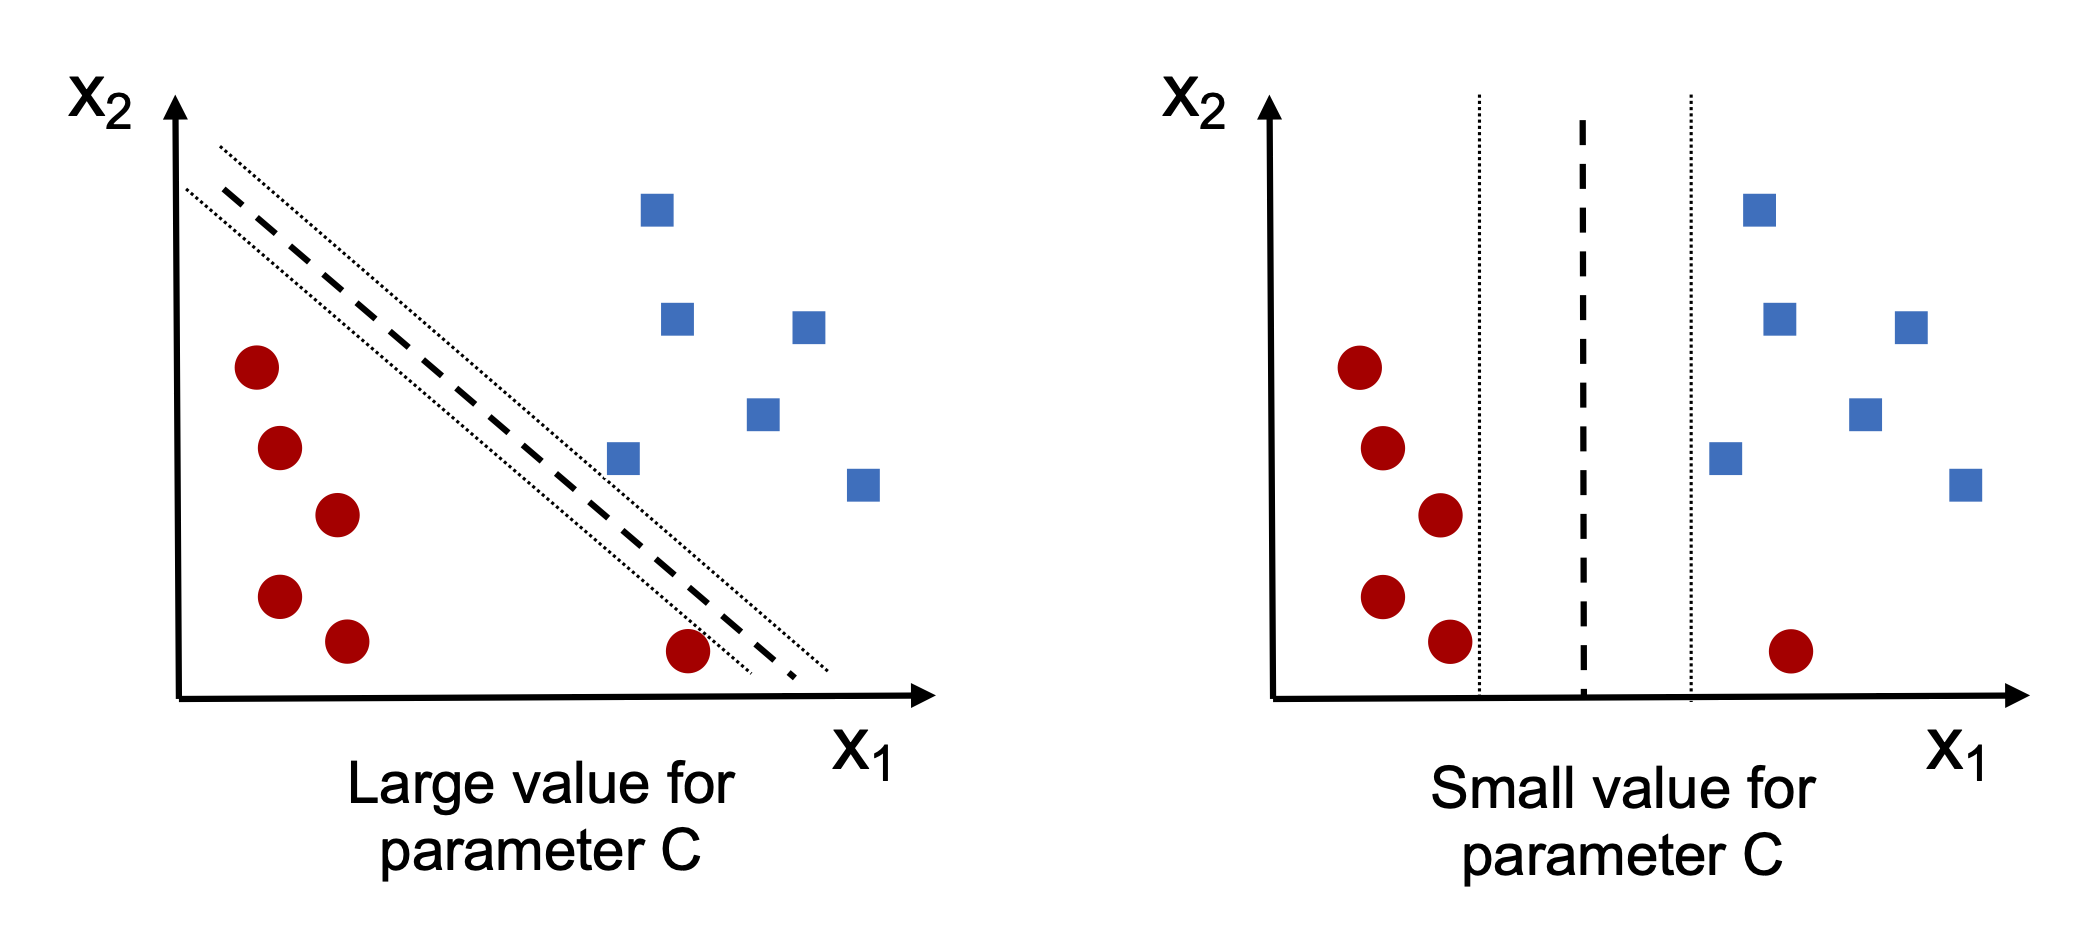

In [27]:
Image(filename='figures/03_10.png', width=600) 

The motivation for introducing the slack variable was that the linear constraints in the SVM optimization objective need to be relaxed for nonlinearly separable data to allow the convergence of the optimization in the presence of misclassifications, under appropriate loss penalization.

The use of the slack variable, in turn, introduces the variable, which is commonly referred to as $C$ in SVM contexts. We can consider $C$ as a hyperparameter for controlling the penalty for misclassification. Large values of $C$ correspond to large error penalties, whereas we are less strict about misclassification errors if we choose smaller values for $C$. We can then use the $C$ parameter to control the width of the margin and therefore tune the bias-variance tradeoff.

This concept is related to regularization, which we discussed in the previous section in the context of regularized regression, where decreasing the value of $C$ increases the bias (underfitting) and lowers the variance (overfitting) of the model.

Let us train an SVM model to classify the different flowers in our Iris dataset:

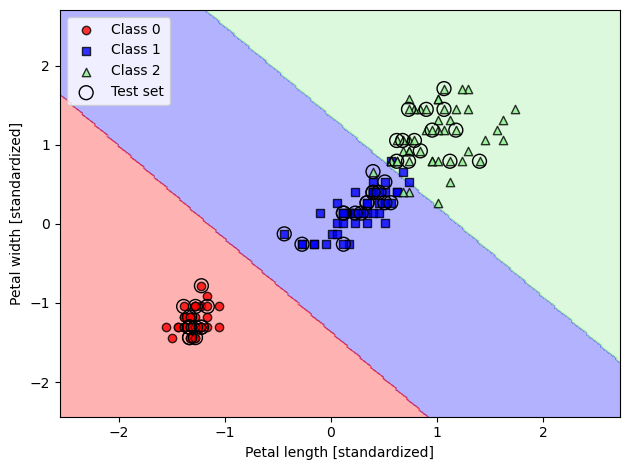

In [28]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_11.png', dpi=300)
plt.show()

## Alternative implementations in scikit-learn

In [29]:
from sklearn.linear_model import SGDClassifier

ppn = SGDClassifier(loss='perceptron')
lr = SGDClassifier(loss='log')
svm = SGDClassifier(loss='hinge')

# Solving non-linear problems using a kernel SVM

Another reason why SVMs enjoy high popularity among machine learning practitioners is that they
can be easily kernelized to solve nonlinear classification problems. Let us first create a synthetic
dataset to see what such a nonlinear classification problem may look like. Using the following code, we will create a simple dataset that has the form of an XOR gate using the <tt>logical_or</tt> function from NumPy, where 100 examples will be assigned the class label 1, and 100 examples will be assigned the class label -1:

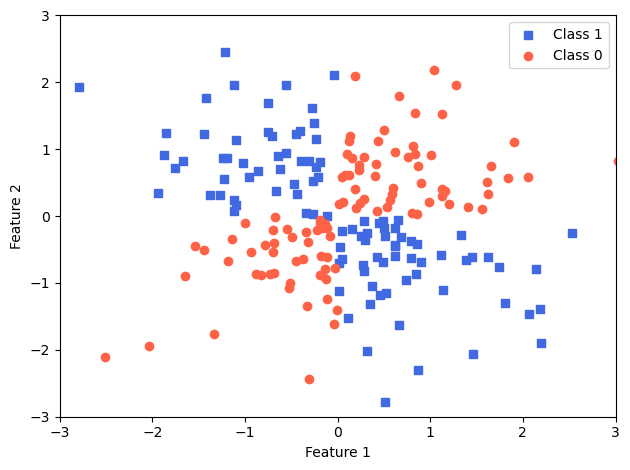

In [30]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='royalblue',
            marker='s',
            label='Class 1')
plt.scatter(X_xor[y_xor == 0, 0],
            X_xor[y_xor == 0, 1],
            c='tomato',
            marker='o',
            label='Class 0')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('figures/03_12.png', dpi=300)
plt.show()

The basic idea behind kernel methods for dealing with such linearly inseparable data is to create
nonlinear combinations of the original features to project them onto a higher-dimensional space via
a mapping function, $\phi$ , where the data becomes linearly separable.

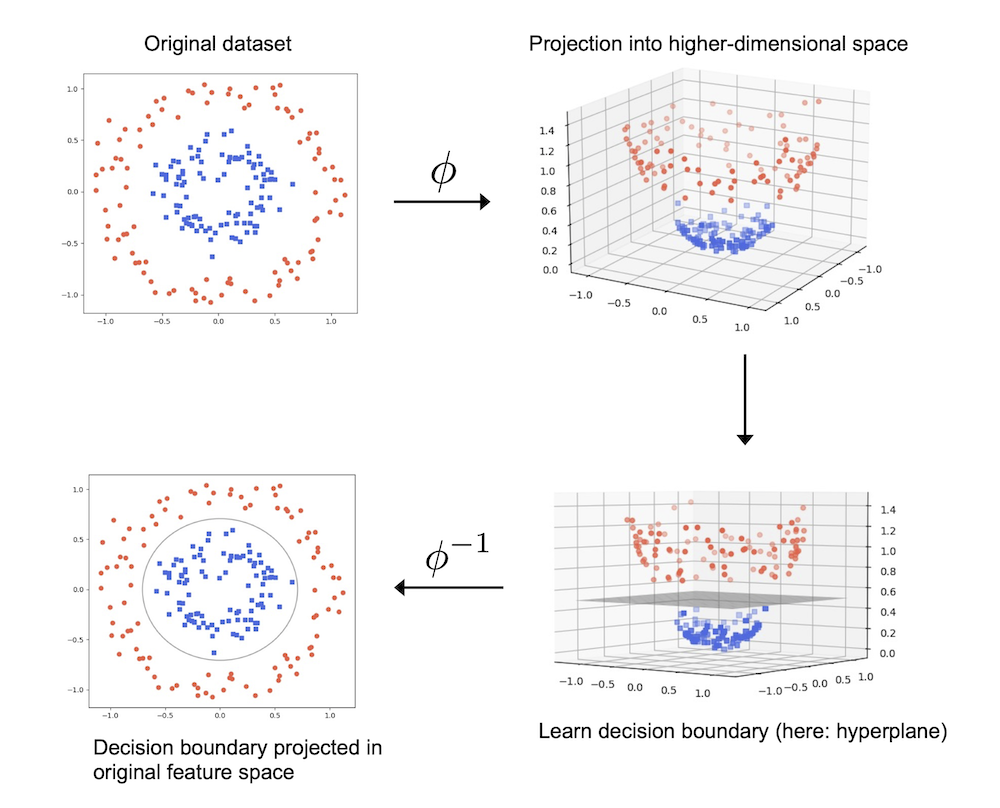

In [31]:
Image(filename='figures/03_13.png', width=700) 

## Using the kernel trick to find separating hyperplanes in higher dimensional space

To solve a nonlinear problem using an SVM, we would transform the training data into a higher-dimensional feature space via a mapping function, $\phi$ , and train a linear SVM model to classify the data in this new feature space. Then, we could use the same mapping function, $\phi$, to transform new, unseen data to classify it using the linear SVM model.

However, one problem with this mapping approach is that the construction of the new features is
computationally very expensive, especially if we are dealing with high-dimensional data. This is where the so-called **kernel trick** comes into play.

To solve the quadratic programming task to train an SVM, in practice, we just need to replace the dot product ${\mathbf{x}^{(i)}}^\top \mathbf{x}^{(j)}$ by $\phi\bigl(\mathbf{x}^{(i)}\bigr)^\top \phi\bigl(\mathbf{x}^{(j)}\bigr).$ To save the expensive step of calculating this dot product between two points explicitly, we define a so-called **kernel function**:
\begin{equation}
\kappa\bigl(\mathbf{x}^{(i)},\mathbf{x}^{(j)}\bigr) = \phi\bigl(\mathbf{x}^{(i)}\bigr)^\top \phi\bigl(\mathbf{x}^{(j)}\bigr).
\end{equation}

$x = [x_1, x_2]$ $y =[y_1, y_2]$ $x \cdot y = x_1 y_1 + x_2 y_2.$

One of the most widely used kernels is the radial basis function (RBF) kernel, which can simply be
called the Gaussian kernel:
\begin{equation}
\kappa\bigl(\mathbf{x}^{(i)},\mathbf{x}^{(j)}\bigr) = \exp \left(-\frac{\| \mathbf{x}^{(i)} - \mathbf{x}^{(j)}\|^2}{2\sigma^2} \right).
\end{equation}
This is often simplified to 
\begin{equation}
\kappa\bigl(\mathbf{x}^{(i)},\mathbf{x}^{(j)}\bigr) = \exp \left(-\gamma \| \mathbf{x}^{(i)} - \mathbf{x}^{(j)}\|^2 \right).
\end{equation}

Here $\gamma = \frac{1}{2\sigma^2}$ is a free parameter to be optimized. Roughly speaking, the term "kernel" can be interpreted as a similarity function between a pair of examples.
The minus sign inverts the distance measure into a similarity score, and, due to the exponential
term, the resulting similarity score will fall into a range between 1 (for exactly similar examples) and 0 (for very dissimilar examples).

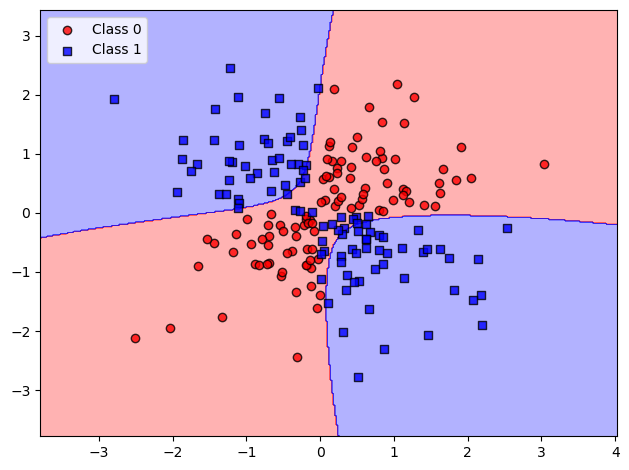

In [32]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_14.png', dpi=300)
plt.show()

The $\gamma$ parameter, which we set to <tt>gamma=0.1</tt>, can be understood as a cut-off parameter for the Gaussian sphere. If we increase the value for $\gamma$, we increase the influence or reach of the training examples, which leads to a tighter and bumpier decision boundary. To get a better understanding of $\gamma$, let us apply an RBF kernel SVM to the Iris flower dataset.

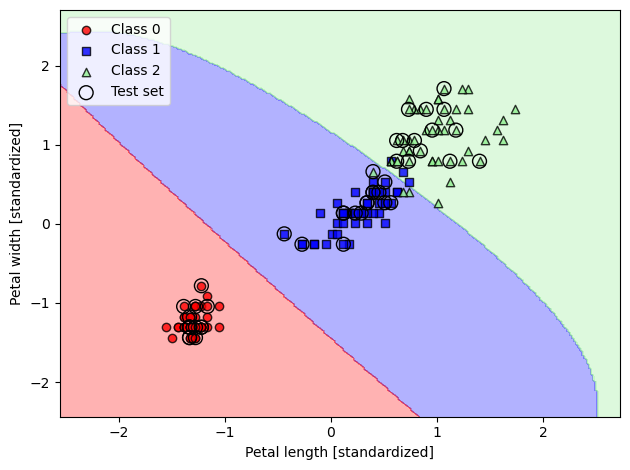

In [33]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Since we chose a relatively small value for $\gamma$ , the resulting decision boundary of the RBF kernel SVM model will be relatively soft.

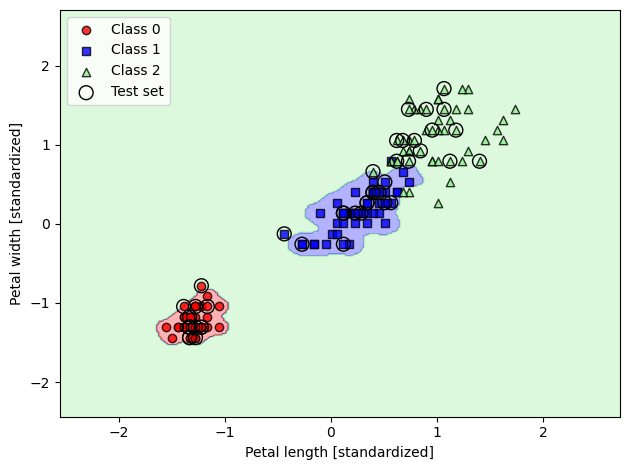

In [34]:
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_16.png', dpi=300)
plt.show()

We can now see that the decision boundary around the classes 0 and 1 is much tighter using a relatively large value of $\gamma$. Although the model fits the training dataset very well, such a classifier will likely have a high generalization error on unseen data. This illustrates that the $\gamma$ parameter also plays an important role in controlling overfitting or variance when the algorithm is too sensitive to fluctuations in the training dataset.